In [1]:
import pandas as pd
import numpy as np

gene_expr_all = pd.read_csv(r"gene/data/tcga_all_gene_expressions_normalized.csv")
signatures = pd.read_csv(r"gene/data/signatures.csv")
# gene_expr.columns = [col.split('_')[0] for col in gene_expr.columns]


In [7]:
mitosis_feats = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final.csv')
# mitosis_feats = mitosis_feats[mitosis_feats["type"]=="PAAD"]

selected_feats = [
"mit_nodeDegrees_mean",
"mit_nodeDegrees_cv",
"mit_nodeDegrees_per99",
"mit_clusterCoff_mean",
"mit_clusterCoff_std",
"mit_clusterCoff_per90",
"mit_cenHarmonic_mean",
"mit_cenHarmonic_std",
"mit_cenHarmonic_per10",
"mit_cenHarmonic_per99",
]

mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")
mitosis_feats["type"] = mitosis_feats["type"].replace(["GBM", "LGG"], "GBMLGG")

cancers = mitosis_feats["type"].unique().tolist()
mitosis_feats = mitosis_feats[["bcr_patient_barcode"]+selected_feats]

# signatures.columns.tolist()

In [8]:
gene_group = "Mitosis"
gene_list = signatures[gene_group].dropna().to_list()
gene_list = [gene+'_rnaseq' for gene in gene_list]
gene_list = [gene for gene in gene_list if gene in gene_expr_all.columns]

# gene_list = "AKAP8,ANAPC10,ANAPC11,ANAPC4,ANAPC5,ANLN,ATM,AURKA,BIRC5,BRSK1,BUB1,BUB1B,CCNA2,CD28,CDC16,CDC23,CDC25B,CDC25C,CDC27,CDCA5,CDK13,CDKN2B,CENPE,CETN1,CHFR,CHMP1A,CIT,CLIP1,DCTN2,DCTN3,DDX11,EGF,EPGN,EREG,ESPL1,GML,KIF11,KIF15,KIF22,KIF25,KIF2C,KNTC1,MAD2L1,MAD2L2,NBN,NCAPH,NDC80,NEK2,NEK6,NOLC1,NPM2,NUMA1,NUSAP1,PAM,PBRM1,PCBP4,PDS5B,PIN1,PKMYT1,PLK1,PML,PPP5C,PRMT5,RAD17,RAN,RCC1,RINT1,SMC1A,SMC3,SMC4,SUGT1,TARDBP,TGFA,TGFB1,TPX2,TRIAP1,TTK,TTN,UBE2C,ZNRD2,ZW10,ZWINT"
# gene_list = gene_list.split(',')
# gene_list = [gene+'_rnaseq' for gene in gene_list]
# gene_list = [gene for gene in gene_list if gene in gene_expr.columns]

gene_expr = gene_expr_all[["case_id"]+gene_list]

In [9]:
# Find the common case names
common_cases = pd.Series(list(set(mitosis_feats['bcr_patient_barcode']).intersection(set(gene_expr['case_id']))))

# Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats[mitosis_feats['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_expr[gene_expr['case_id'].isin(common_cases)]

# Sort the dataframes based on 'case_name'
df1_common = df1_common.sort_values('bcr_patient_barcode')
df2_common = df2_common.sort_values('case_id')

# Remove duplicate rows based on 'case_name' in df2_common
df2_common = df2_common.drop_duplicates(subset='case_id')

# Convert the dataframes to numpy arrays
X = df1_common.drop(columns='bcr_patient_barcode')#.values
Y = df2_common.drop(columns='case_id')#.values
Y = Y.dropna(axis=1, how="all")

In [10]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler() 
# X = scaler.fit_transform(X) #scale data
# Y = scaler.fit_transform(Y) 

from utils import get_colors_dict
cancer_colors = get_colors_dict()
color_list = [cancer_colors[cancer] for cancer in Y["type"]]
Y.drop("type", axis=1, inplace=True)


KeyError: 'type'

In [11]:
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.patches as mpatches

# Initialize CCA
plsca = CCA(n_components=2, scale=True)

# Initialize KFold
kf = KFold(n_splits=4)

# Initialize lists to store results
X_r_vals = []
Y_r_vals = []

xrots = []
yrots = []

# Perform 5-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

    plsca.fit(X_train, Y_train)
    X_r_val, Y_r_val = plsca.transform(X_val, Y_val)

    X_r_vals.append(X_r_val)
    Y_r_vals.append(Y_r_val)

    xrots.append(plsca.x_rotations_)
    yrots.append(plsca.y_rotations_)

# Concatenate results
X_r_vals = np.concatenate(X_r_vals, axis=0)
Y_r_vals = np.concatenate(Y_r_vals, axis=0)

# On-diagonal plot: X vs Y scores for each component
plt.figure(figsize=(4.4, 4.4))

res = stats.spearmanr(X_r_vals[:, 0], Y_r_vals[:, 0])
print(f"Spearman correlation coefficient: {res.statistic}")
print(f"P-value: {res.pvalue}")

res = stats.pearsonr(X_r_vals[:, 0], Y_r_vals[:, 0])
print(f"Pearsons correlation coefficient: {res.statistic}")
print(f"P-value: {res.pvalue}")

# Component 1
plt.scatter(X_r_vals[:, 0], Y_r_vals[:, 0], marker="o", color=color_list, s=5, alpha=0.2)
plt.xlabel("Mitotic Features 1st Component")
plt.ylabel("Mitosis Genes 1st Component")
plt.title(
    "Pearson correlation = %.2f"  %res.statistic
    # % np.corrcoef(X_r_vals[:, 0], Y_r_vals[:, 0])[0, 1]
)
plt.xticks(())
plt.yticks(())

# add legend
legend_elements = [mpatches.Patch(color=color, label=domain) for domain, color in cancer_colors.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1.02), ncol=2)

# plt.legend()
# plt.savefig(f"gene/canonical_corr/cv_cca_pearson_all-mitosis.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)
# plt.savefig(f"gene/canonical_corr/cv_cca_pearson_all-mitosis.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)




ValueError: at least one array or dtype is required

In [29]:
xrot = np.mean(np.stack(xrots, 2), axis=2)
yrot = np.mean(np.stack(yrots, 2), axis=2)

Spearman correlation coefficient: 0.7575217751068642
P-value: 0.0


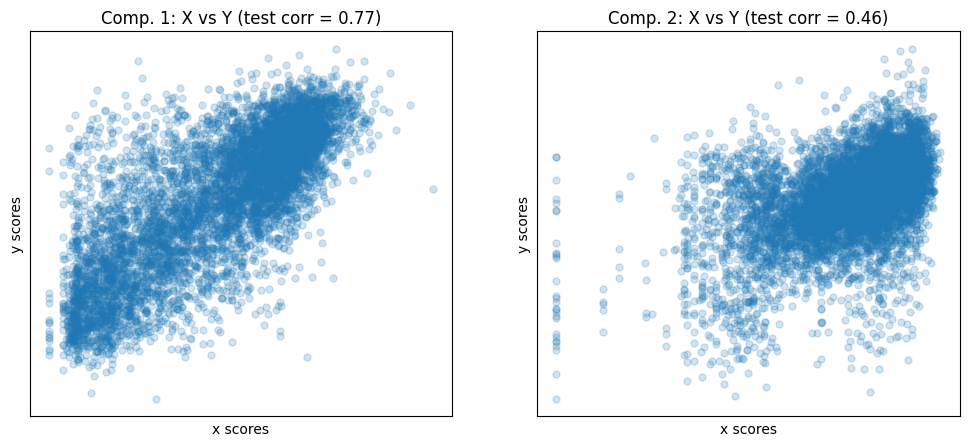

In [11]:
from sklearn.cross_decomposition import PLSCanonical, CCA
import matplotlib.pyplot as plt

# plsca = PLSCanonical(n_components=2)
plsca = CCA(n_components=2,scale=True)
X_r, Y_r = plsca.fit_transform(X, Y)



# On diagonal plot X vs Y scores on each components
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X_r[:, 0], Y_r[:, 0], marker="o", s=25, alpha=0.2)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title(
    "Comp. 1: X vs Y (test corr = %.2f)"
    % np.corrcoef(X_r[:, 0], Y_r[:, 0])[0, 1]
)
plt.xticks(())
plt.yticks(())

# plt.gca().set_aspect('equal')

plt.subplot(122)
plt.scatter(X_r[:, 1], Y_r[:, 1], marker="o", s=25, alpha=0.2)
plt.xlabel("x scores")
plt.ylabel("y scores")
plt.title(
    "Comp. 2: X vs Y (test corr = %.2f)"
    % np.corrcoef(X_r[:, 1], Y_r[:, 1])[0, 1]
)
plt.xticks(())
plt.yticks(())
# plt.gca().set_aspect('equal')

res = stats.spearmanr(X_r[:, 0], Y_r[:, 0])
print(f"Spearman correlation coefficient: {res.statistic}")
print(f"P-value: {res.pvalue}")


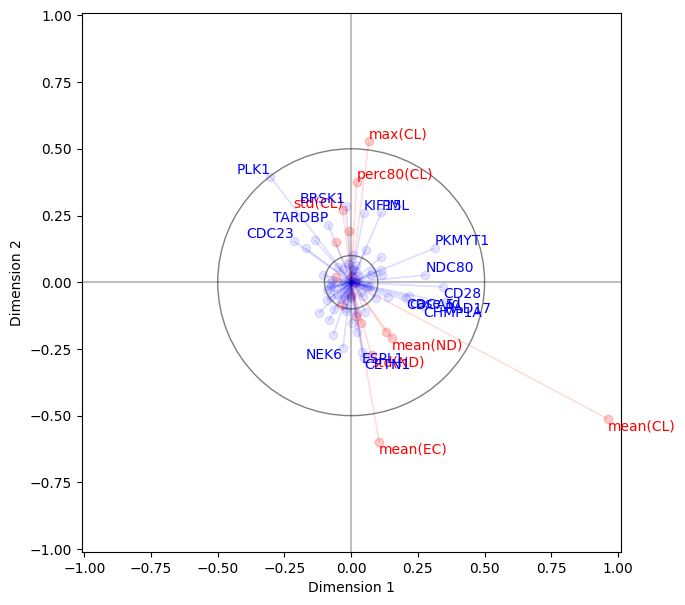

In [12]:
import numpy as np
from utils import featre_to_tick
def decide_alignment(x, y):
  if x<0 and y<0:
    h, v = "right", "top"
  if x<0 and y>0:
    h, v = "right", "bottom"
  if x>0 and y>0:
    h, v = "left", "bottom"
  if x>0 and y<0:
    h, v = "left", "top"
  return h,v

# # Obtain the rotation matrices
xrot = plsca.x_rotations_
yrot = plsca.y_rotations_

# fig, ax = plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(figsize=(7, 7)) 
plt.xlim((-1.01,1.01))
plt.ylim((-1.01,1.01))

x_names = df1_common.columns[1:]
y_names = df2_common.columns[1:]

# first draw circles
circle1 = plt.Circle((0, 0), 0.1, fill=False, color='black', alpha=0.5)
circle2 = plt.Circle((0, 0), 0.5, fill=False, color='black', alpha=0.5)
circle3 = plt.Circle((0, 0), 1.0, fill=False, color='black', alpha=0.5)
ax.add_patch(circle1)
ax.add_patch(circle2)
# ax.add_patch(circle3)
plt.axhline(0, color='black', alpha=0.25)
plt.axvline(0, color='black', alpha=0.25)
viz_thresh = 0.2
for vi, var in enumerate(xrot):
  var = np.clip(var, -1, 1)
  # print(var)
  plt.arrow(0,0,var[0],var[1], color='red', alpha=0.1, head_width=0)
  plt.scatter(var[0],var[1], color='red', alpha=0.2,)
  h, v = decide_alignment(var[0], var[1])
  if abs(var[0])>viz_thresh or abs(var[1])>viz_thresh:
    plt.text(var[0],var[1],featre_to_tick(x_names[vi]), color='red', horizontalalignment=h, verticalalignment=v)

for vi, var in enumerate(yrot):
  plt.arrow(0,0,var[0],var[1], color='blue', alpha=0.1, head_width=0)
  plt.scatter(var[0],var[1], color='blue', alpha=0.1,)
  h, v = decide_alignment(var[0], var[1])
  if abs(var[0])>viz_thresh or abs(var[1])>viz_thresh:
    plt.text(var[0],var[1],y_names[vi], color='blue', horizontalalignment=h, verticalalignment=v)



ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_aspect('equal')

plt.savefig(f"gene/canonical_corr/cv_cca_rot_all-mitosis.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)
plt.savefig(f"gene/canonical_corr/cv_cca_rot_all-mitosis.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)

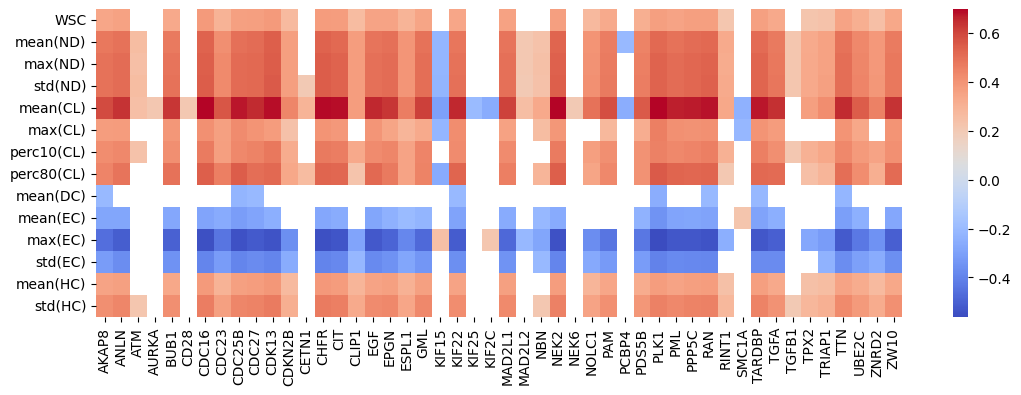

In [14]:
# Heatmap-like functional classification
def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)

def calculate_corr_matrix(df1, df2, method='spearman'):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")

    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            if method == 'spearman':
                corr, _ = stats.spearmanr(df1[row], df2[col])
            elif method == 'pearson':
                corr, _ = stats.pearsonr(df1[row], df2[col])
            corr_matrix.at[row, col] = np.float32(corr)
    return corr_matrix

X_norm = (X-X.mean()) / X.std()
Y_norm = (Y-Y.mean()) / Y.std()
X_norm.columns = [featre_to_tick(col) if col != 'bcr_patient_barcode' else col for col in X_norm.columns]
corr_matrix = calculate_corr_matrix(X_norm, Y_norm, method="pearson")
corr_matrix[corr_matrix.abs()<0.2] = np.nan
corr_matrix = corr_matrix.dropna(axis='columns', how='all')
corr_matrix = corr_matrix.dropna(axis='rows', how='all') # shoul keep?


import seaborn as sns
fig = plt.figure(figsize=(13,4))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.savefig(f"gene/func_heatmap_corr/func_pearson_all-mitosis.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)
plt.savefig(f"gene/func_heatmap_corr/func_pearson_all-mitosis.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)

/tmp/ipykernel_3161120/3970425423.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.47111434820051196' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  corr_matrix.at[row, col] = corr
/tmp/ipykernel_3161120/3970425423.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6035691839016439' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  corr_matrix.at[row, col] = corr
/tmp/ipykernel_3161120/3970425423.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5817142005133946' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  corr_matrix.at[row, col] = corr
/tmp/ipykernel_3161120/3970425423.py:17: FutureWarning: Setting an item of incompatible dtype

<Figure size 640x480 with 0 Axes>

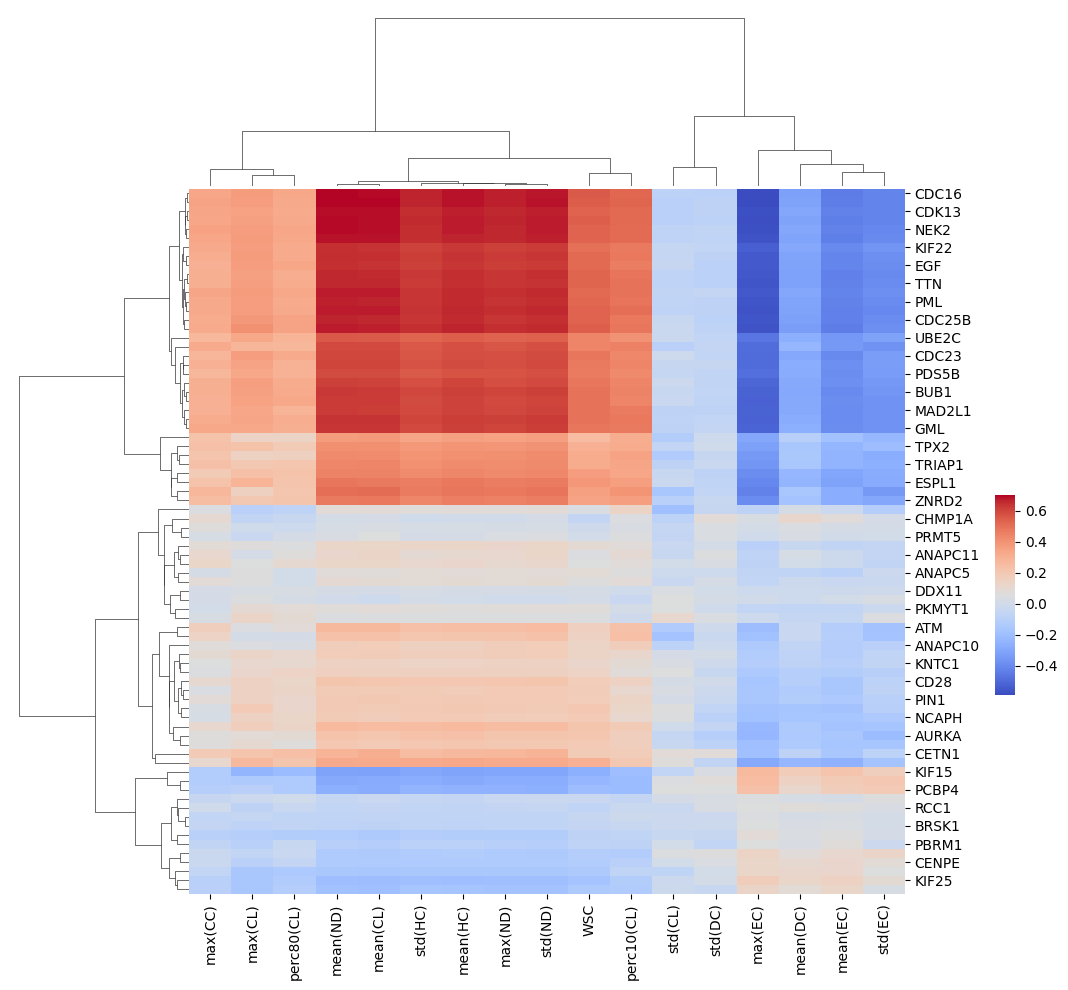

In [21]:
# biclustering of correlation matrix

# Function to calculate Spearman correlation matrix
from scipy.stats import spearmanr, pearsonr
def calculate_corr_matrix(df1, df2, method='spearman', correct_pvalue_based_on="df1"):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")

    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    pvalue_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            if method == 'spearman':
                corr, pvalue = spearmanr(df1[row], df2[col])
            elif method == 'pearson':
                corr, pvalue = pearsonr(df1[row], df2[col])
            corr_matrix.at[row, col] = corr
            pvalue_matrix.at[row, col] = pvalue
    # correcting pvalues for the number of genes
    if correct_pvalue_based_on=="df1":
        scale = len(df1.columns)
    else:
        scale = len(df2.columns)
    pvalue_matrix = pvalue_matrix * scale
    return corr_matrix, pvalue_matrix

# Calculate the Spearman correlation matrix
spearman_correlation_matrix, spearman_pvalue_matrix = calculate_corr_matrix(Y_norm, X_norm, method='spearman', correct_pvalue_based_on="df1")

# Calculate the Pearson correlation matrix
pearson_correlation_matrix, pearson_pvalue_matrix = calculate_corr_matrix(Y_norm, X_norm, method='pearson', correct_pvalue_based_on="df1")

# plt.figure()
# sns.clustermap(pearson_correlation_matrix, cmap="coolwarm", cbar_pos=(1.0, 0.3, 0.02, 0.2), method='ward')

plt.figure()
sns.clustermap(spearman_correlation_matrix, cmap="coolwarm", cbar_pos=(1.0, 0.3, 0.02, 0.2), method='centroid')

plt.savefig(f"gene/bicluster_cross_corr/all_bicluster_pearson_all-mitosis.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)
plt.savefig(f"gene/bicluster_cross_corr/all_bicluster_pearson_all-mitosis.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)

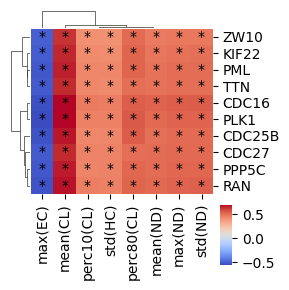

In [85]:
## top params: figsize

corr_matrix = pearson_correlation_matrix.copy()
plvalue_matrix = pearson_pvalue_matrix.copy()
df_filtered = corr_matrix.copy()
threshold = 0.4 # top: 0.2, toptop: 0.4
df_filtered[df_filtered.abs()<threshold] = np.nan
# filter the non-significant correlations
df_filtered[plvalue_matrix>0.01] = np.nan

threshold_percentage_rows = 50 # top:50 toptop:50
threshold_percentage_cols = 30 # top:10 toptop:30
fig_size = (3,3) # top:(10, 10) toptop:(3, 3)
dendo_ratio = (0.1,0.1) # top:(0.1, 0.1) topTop: (0.1, 0.1)
cbar_pos= (0.75, 0.1, 0.04, 0.2)  # top: (0.75, 0.1, 0.04, 0.2) topTop: (0.75, 0.15, 0.02, 0.15)

# Calculate the number of non-NaN values in each row
non_nan_counts_rows = df_filtered.count(axis=1)
# Calculate the total number of cells in each row
total_cells_rows = df_filtered.shape[1]
# Calculate the percentage of non-NaN values
percentage_non_nan_rows = (non_nan_counts_rows / total_cells_rows) * 100

# Calculate the number of non-NaN values in each column
non_nan_counts_cols = df_filtered.count(axis=0)
# Calculate the total number of cells in each column
total_cells_cols = df_filtered.shape[0]
# Calculate the percentage of non-NaN values
percentage_non_nan_cols = (non_nan_counts_cols / total_cells_cols) * 100

# Filter out rows where the percentage is below the threshold
filtered_corr_matrix_rows = corr_matrix[percentage_non_nan_rows > threshold_percentage_rows]
filtered_plvalue_matrix_rows = plvalue_matrix[percentage_non_nan_rows > threshold_percentage_rows]

# Filter out columns where the percentage is below the threshold
final_corr_matrix = filtered_corr_matrix_rows.loc[:, percentage_non_nan_cols > threshold_percentage_cols]
final_plvalue_matrix = filtered_plvalue_matrix_rows.loc[:, percentage_non_nan_cols > threshold_percentage_cols]

# Create a mask where p-value < 0.01
significant = final_plvalue_matrix < 0.01

# Create a clustermap
g = sns.clustermap(final_corr_matrix, cmap="coolwarm",  method="ward", yticklabels=True,
                   figsize=fig_size, dendrogram_ratio=dendo_ratio, cbar_pos=cbar_pos,
                   )

# Get the labels of the rows and columns from the clustermap
row_labels = g.dendrogram_row.reordered_ind
col_labels = g.dendrogram_col.reordered_ind

# Add asterisks to the cells where the mask is True
for text in g.ax_heatmap.texts:
    text.set_visible(False)
for i, row_label in enumerate(row_labels):
    for j, col_label in enumerate(col_labels):
        if significant.iloc[row_label, col_label]:
            g.ax_heatmap.text(j+0.5, i+0.5, '*', ha='center', va='center', color='black')

# plt.savefig(f"gene/bicluster_cross_corr/topTop_bicluster_pearson_all-mitosis.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0)
# plt.savefig(f"gene/bicluster_cross_corr/topTop_bicluster_pearson_all-mitosis.png", dpi=600, bbox_inches = 'tight', pad_inches = 0)

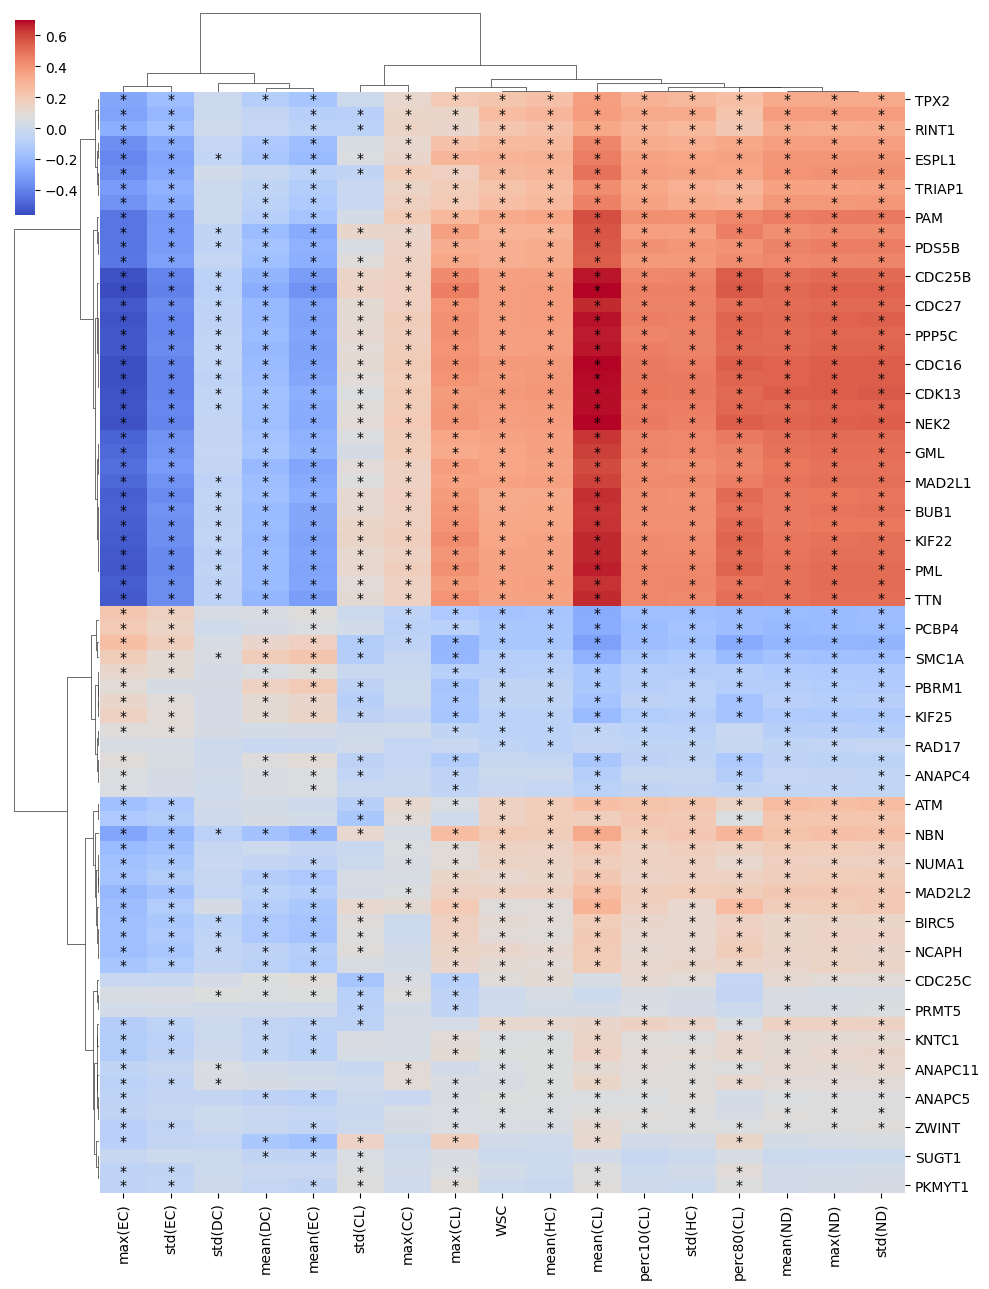

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clustermap(corr_matrix, plvalue_matrix, mode):
    # Set parameters based on the mode
    if mode == 'top':
        threshold = 0.2
        threshold_percentage_rows = 50
        threshold_percentage_cols = 10
        fig_size = (10, 10)
        dendo_ratio = (0.1, 0.1)
        cbar_pos= (0.02, 0.83, 0.02, 0.15)
        y_ticks = True
    elif mode == 'topTop':
        threshold = 0.4
        threshold_percentage_rows = 50
        threshold_percentage_cols = 30
        fig_size = (3, 3)
        dendo_ratio = (0.1, 0.1)
        cbar_pos= (0.75, 0.15, 0.02, 0.15)
        y_ticks = True
    elif mode == 'all':
        threshold = 0.05
        threshold_percentage_rows = 10
        threshold_percentage_cols = 0
        fig_size = (10, 13)
        dendo_ratio = (0.1, 0.07)
        cbar_pos= (0.02, 0.83, 0.02, 0.15)
        y_ticks = "auto"
    else:
        raise ValueError("Invalid mode. Choose either 'top' or 'topTop'.")

    df_filtered = corr_matrix.copy()
    df_filtered[df_filtered.abs()<threshold] = np.nan
    df_filtered[plvalue_matrix>0.01] = np.nan

    non_nan_counts_rows = df_filtered.count(axis=1)
    total_cells_rows = df_filtered.shape[1]
    percentage_non_nan_rows = (non_nan_counts_rows / total_cells_rows) * 100

    non_nan_counts_cols = df_filtered.count(axis=0)
    total_cells_cols = df_filtered.shape[0]
    percentage_non_nan_cols = (non_nan_counts_cols / total_cells_cols) * 100

    filtered_corr_matrix_rows = corr_matrix[percentage_non_nan_rows > threshold_percentage_rows]
    filtered_plvalue_matrix_rows = plvalue_matrix[percentage_non_nan_rows > threshold_percentage_rows]

    final_corr_matrix = filtered_corr_matrix_rows.loc[:, percentage_non_nan_cols > threshold_percentage_cols]
    final_plvalue_matrix = filtered_plvalue_matrix_rows.loc[:, percentage_non_nan_cols > threshold_percentage_cols]

    significant = final_plvalue_matrix < 0.01

    g = sns.clustermap(final_corr_matrix, cmap="coolwarm",  method="ward", yticklabels=y_ticks,
                       figsize=fig_size, dendrogram_ratio=dendo_ratio, cbar_pos=cbar_pos)

    row_labels = g.dendrogram_row.reordered_ind
    col_labels = g.dendrogram_col.reordered_ind

    for text in g.ax_heatmap.texts:
        text.set_visible(False)
    for i, row_label in enumerate(row_labels):
        for j, col_label in enumerate(col_labels):
            if significant.iloc[row_label, col_label]:
                g.ax_heatmap.text(j+0.5, i+0.5, '*', ha='center', va='center', color='black')

    return g.fig

corr_matrix = pearson_correlation_matrix.copy()
plvalue_matrix = pearson_pvalue_matrix.copy()

fig = plot_clustermap(corr_matrix, plvalue_matrix, "all")
# fig.savefig("mosi.png")